In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import albumentations as A
import cv2
from PIL import Image, ImageDraw, ImageFont

def draw_bboxes(
    image_np: np.ndarray,
    bboxes_np: np.ndarray,
    labels_np: np.ndarray,
    color: tuple = (255, 0, 0),
    font_size: int = 16,
    thickness: int = 2,
) -> Image.Image:
    """
    在图像上绘制边界框和标签（支持中文）

    Args:
        image_np (np.ndarray): shape (H, W, 3), dtype uint8
        bboxes_np (np.ndarray): shape (N, 4), xyxy格式, dtype int32
        labels_np (np.ndarray or list): 长度为N的字符串数组或列表
        color (tuple): 边界框和文字颜色，默认红色 (R, G, B)
        font_size (int): 标签字体大小
        thickness (int): 边界框线宽

    Returns:
        Image.Image: 绘制完成的PIL图像
    """
    # 转换为PIL图像
    img = Image.fromarray(image_np)
    draw = ImageDraw.Draw(img)

    # 加载字体（支持中文）
    font_path = "/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc"
    try:
        font = ImageFont.truetype(font_path, font_size)
    except Exception as e:
        print(f"[Warning] Failed to load font {font_path}: {e}, using default font.")
        font = ImageFont.load_default()

    # 转换边界框为 (x1, y1, x2, y2) 格式
    for i, box in enumerate(bboxes_np):
        label = labels_np[i]

        x1, y1, x2, y2 = map(int, box)

        # 绘制矩形框
        draw.rectangle([x1, y1, x2, y2], outline=color, width=thickness)

        # 计算文本尺寸
        text_bbox = draw.textbbox((0, 0), label, font=font)
        text_w = text_bbox[2] - text_bbox[0]
        text_h = text_bbox[3] - text_bbox[1]

        # 文本背景区域
        text_bg_rect = [x1, y1 - text_h - 5, x1 + text_w, y1]
        draw.rectangle(text_bg_rect, fill=color)

        # 绘制文本
        draw.text((x1, y1 - text_h - 5), label, fill=(255, 255, 255), font=font)

    return img

def visualize_bbox_augmentations(image, bboxes, labels, transform, samples=5):
    """Visualizes original image and augmented versions."""
    # Prepare visualization pipeline (strip Normalize, ToTensor)
    figure, ax = plt.subplots(1, samples + 1, figsize=(15, 5))

    # Draw original
    original_drawn = draw_bboxes(image, bboxes, labels)
    ax[0].imshow(original_drawn)
    ax[0].set_title("Original")
    ax[0].axis("off")

    # Draw augmented samples
    for i in range(samples):
        # Apply the visualization transform
        # Ensure labels are passed correctly based on label_fields
        augmented = transform(image=image, bboxes=bboxes, labels=labels)

        aug_image = augmented['image']
        aug_bboxes = augmented['bboxes']
        aug_labels = augmented['labels']

        augmented_drawn = draw_bboxes(aug_image, aug_bboxes, aug_labels)
        ax[i+1].imshow(augmented_drawn)
        ax[i+1].set_title(f"Augmented {i+1}")
        ax[i+1].axis("off")

    plt.tight_layout()
    plt.show()

def yolo2pascal_voc(bboxes, h, w):
    bboxes = bboxes.copy()
    bboxes[:, [0, 2]] *= w
    bboxes[:, [1, 3]] *= h
    bboxes[:, 0] -= bboxes[:, 2] / 2
    bboxes[:, 1] -= bboxes[:, 3] / 2
    bboxes[:, 2] = bboxes[:, 0] + bboxes[:, 2]
    bboxes[:, 3] = bboxes[:, 1] + bboxes[:, 3]
    bboxes = np.round(bboxes).astype(np.int32)
    return bboxes

/data/16t/wxh/LitDetect/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
img_root = Path('/data/16t/lrh/datasets/胎儿超声/小类/训练/脊柱/images/train2017/')
anno_root = Path('/data/16t/lrh/datasets/胎儿超声/小类/训练/脊柱/labels/train2017/')
class_name = ['纵切面', '横切面', '冠状面']

In [9]:
imgs = list(img_root.glob('*.png'))
datas = []
for img in imgs:
    img_path: Path = img
    anno_path = img_path.with_suffix('.txt')
    anno_path = anno_root / anno_path.name
    assert anno_path.exists()
    datas.append([img_path, anno_path])
print(f"Total images: {len(datas)}")

Total images: 3560


In [10]:
idx = 500

In [11]:
# idx = 500
img_path, anno_path = datas[idx]
ano = np.loadtxt(anno_path, dtype=np.float32)
if len(ano) == 0:
    raise NotImplementedError
else:
    if len(ano.shape) == 1:
        ano = ano[None]
image = Image.open(img_path).convert('RGB')
image = np.array(image)
h, w = image.shape[:2]
bboxes = yolo2pascal_voc(ano[:, 1:], h, w)
class_labels = np.array([class_name[int(i)] for i in ano[:, 0]])
print(class_labels, bboxes)

['纵切面'] [[326 217 679 309]]


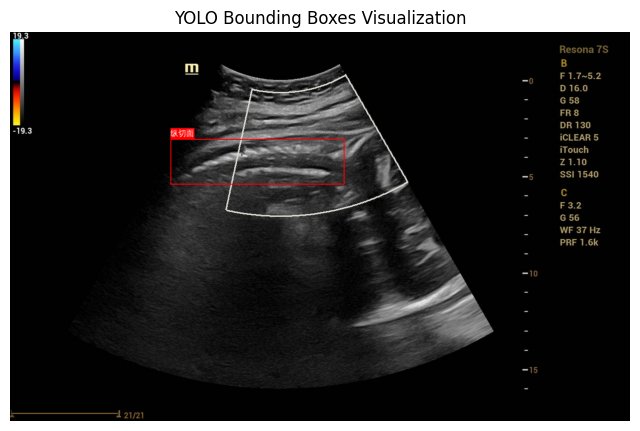

In [12]:
original_drawn = draw_bboxes(image, bboxes, class_labels)
plt.figure(figsize=(8, 8))
plt.title("YOLO Bounding Boxes Visualization")
plt.axis('off')  # 关闭坐标轴
plt.imshow(np.array(original_drawn))
plt.show()

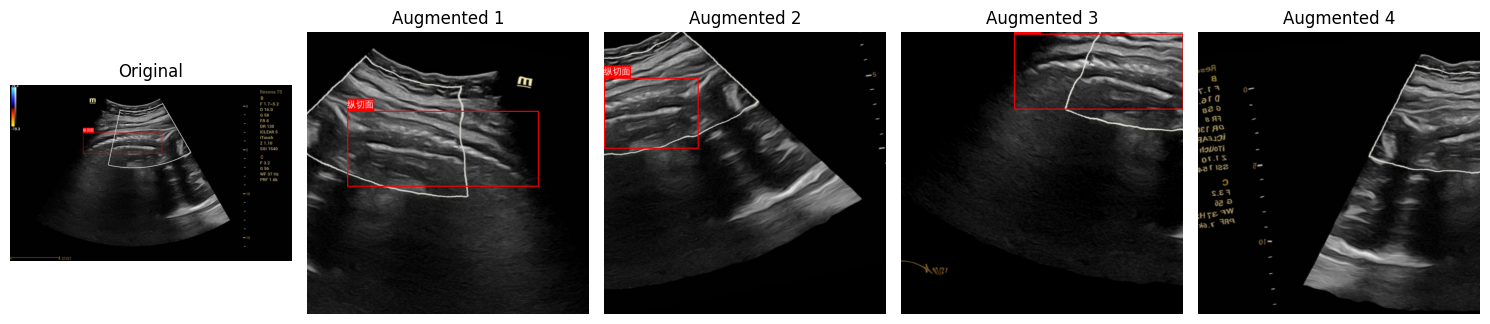

In [13]:
# Define the transform (must include bbox_params with correct format and label_fields)
train_transform = A.Compose([

    A.ElasticTransform(
        alpha=300,
        sigma=10,
        interpolation=cv2.INTER_LINEAR,
        approximate=False,
        same_dxdy=True,
        mask_interpolation=cv2.INTER_NEAREST,
        noise_distribution="gaussian",
        keypoint_remapping_method="mask",
        border_mode=cv2.BORDER_CONSTANT,
        fill=0,
        fill_mask=0,
        p=1.,
    ),
    A.Affine(
        scale=(0.8, 1.2),  # Zoom in/out by 80-120%
        rotate=(-15, 15),  # Rotate by -15 to +15 degrees
        balanced_scale=True,
        p=1.0
    ),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Sequential([
        A.SmallestMaxSize(max_size=640, p=1.0),
        A.RandomCrop(height=512, width=512)
    ], p=1.),
    # A.Normalize(...), # 现在别用，训练的时候加
    # A.ToTensorV2(),  # 现在别用，训练的时候加
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'], min_visibility=0.5))

visualize_bbox_augmentations(image, bboxes, class_labels, train_transform, samples=4)